# **Smart-UJ UAQUE**
Este Notebook hace parte del servicio inteligente "perfil grupal" y tiene como principal objetivo la generación de grupos a partir de las carácteristicas de los usuarios, incluyendo sus gustos y preferencias de lectura obtenidos a partir del historial de prestamos de material bibliográfico físico en la biblioteca Alfonso Borrero Cabal S.J.

Para formar estos grupos se realizarán varios acercamientos con diferentes técnicas, algóritmos y aproximaciones a partir de los modelos de recomendación clásicos. Posteriormente, se escogerá el mejor modelo para el sistema de recomendación y los grupos serán exportados al servicio inteligente "Servicio de recomedación UAQUE".

**Integrantes:**</br>
Johan Ortegón </br>
Juan Angarita </br>
Jorge Salgado </br>
Daniel Tibaquira </br></br>
**Directora de Proyecto de Grado:** </br>
Viky Arias </br>


#Importación de datos

# Primero importamos el drive para poder leer los archivos

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Estas son las librerias que vamos a usar para hacer el join de ambas tablas y poder hacer las diferentes agrupaciones de estudiantes. 

* pandas(pd): Permite almacenar los datos en dataframes(matrices) y operación entre las celdas.

In [49]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

Importamos ambos archivos y los guardamos como dataframes de panda en las siguientes variables:
* dataserPrestamos: Prestamos biblioteca
* datasetMaterial: Materiales biblioteca

In [50]:
datasetPrestamos = pd.read_json('/content/drive/MyDrive/UAQUE/PRESTAMOS-BIBLIOTECA-POSTLIMPIEZA.json')

In [51]:
datasetMaterial = pd.read_json('/content/drive/MyDrive/UAQUE/MATERIALES-BIBLIOTECA-POSTLIMPIEZA.json')

A continuación se muestra la estructura básica de ambos archivos

In [52]:
display(datasetPrestamos.head())
display(datasetMaterial.head())

,row ID,Mes,Fecha,Hora,Transacción,Biblioteca Transacción,ID Ítem,Numero de Ubicación,Dewey,Ubicación,Tipo de ítem,Llaves,Perfil,Categoría 1,Programa,Facultad,ID de usuario ok,Año
0,Row0,Enero,1547050497000,16.0,Prestamos CyP,B-GENERAL,80000005327627,720.98 A71S,720,COL-GRAL-2,LIBRO,866245.0,A-EGRESADO,ARQUI,carrera de arquitectura,arquitectura y diseño,c361c772cd0220bb16dcfb2ad803e4903334ab94,2019
1,Row1,Enero,1547050500000,16.0,Prestamos CyP,B-GENERAL,80000001191496,720.9861 A71,720,COL-GRAL-2,LIBRO,309945.0,A-EGRESADO,ARQUI,carrera de arquitectura,arquitectura y diseño,c361c772cd0220bb16dcfb2ad803e4903334ab94,2019
2,Row2,Enero,1547138763000,16.0,Prestamos CyP,B-GENERAL,80000004979759,540 CH15Q 2010,540,COL-GRAL-3,LIBRO,822727.0,A-EGRESADO,ARQUI,carrera de arquitectura,arquitectura y diseño,87b0e5a61ed712ddfaf5d478ad68c87c825997e9,2019
3,Row3,Enero,1547138765000,16.0,Prestamos CyP,B-GENERAL,80000004509512,512 B151,510,COL-GRAL-3,LIBRO,784541.0,A-EGRESADO,ARQUI,carrera de arquitectura,arquitectura y diseño,87b0e5a61ed712ddfaf5d478ad68c87c825997e9,2019
4,Row4,Enero,1547300269000,13.0,Prestamos CyP,B-GENERAL,80000005270756,712 M17E,710,COL-GRAL-2,LIBRO,858473.0,A-EGRESADO,ARQUI,carrera de arquitectura,arquitectura y diseño,afe8c17ba351d274fc5671978918f0c93032d88f,2019


,Signatura,Id de item,Ubicación Habitual,Ubicación Actual,Tipo de ítem,Biblioteca,Cat2,Fecha de creación,Total de préstamos,Llaves,Vol,Copias,Autor,Autor corporativo,Título,Tema 650,Año publicación,Todas las temáticas
0,925.2 C66NA|,60000000049754,A-BATEMAN,A-BATEMAN,LIBRO,B-GENERAL,DONACION,2019,0,933604,1,1,"Álvarez Ríos, Baldomero 1924-",None,Copernico gigante del Renacimiento Baldomero A...,Astrónomos Polonia Biografías,1973.0,"[Astronomos, Polonia, Biografias]"
1,925.2 C66NC V.3|,60000000049751,A-BATEMAN,A-BATEMAN,LIBRO,B-GENERAL,DONACION,2019,0,933606,1,1,None,"Academia de Ciencias Médicas, Físicas y Natura...","Nicolás Copérnico, 500 aniversario, 1473-1973",Astronomía Historia,1973.0,"[Astronomia, Historia24, Astronomos, Polonia, ..."
2,925.2 C66NC V.1|,60000000049753,A-BATEMAN,A-BATEMAN,LIBRO,B-GENERAL,DONACION,2019,0,933606,2,1,None,"Academia de Ciencias Médicas, Físicas y Natura...","Nicolás Copérnico, 500 aniversario, 1473-1973",Astronomía Historia,1973.0,"[Astronomia, Historia24, Astronomos, Polonia, ..."
3,925.2 C66NC V.1|,60000000049765,A-BATEMAN,A-BATEMAN,LIBRO,B-GENERAL,DONACION,2019,0,933606,2,2,None,"Academia de Ciencias Médicas, Físicas y Natura...","Nicolás Copérnico, 500 aniversario, 1473-1973",Astronomía Historia,1973.0,"[Astronomia, Historia24, Astronomos, Polonia, ..."
4,925.2 C66NC V.2|,60000000049752,A-BATEMAN,A-BATEMAN,LIBRO,B-GENERAL,DONACION,2019,0,933606,3,1,None,"Academia de Ciencias Médicas, Físicas y Natura...","Nicolás Copérnico, 500 aniversario, 1473-1973",Astronomía Historia,1973.0,"[Astronomia, Historia24, Astronomos, Polonia, ..."


Dado que la columna de llaves de ambas tablas vienen en diferentes formatos es necesario formatearlas a String.

In [53]:
datasetPrestamos['Llaves'] = datasetPrestamos['Llaves'].apply(lambda x: str(x)[:-2])
datasetMaterial['Llaves'] = datasetMaterial['Llaves'].apply(lambda x: str(x))

Analizaremos la cantidad atributos "llaves" diferentes que tiene cada una de las tablas. Esto adicionalmente no dirá cuanto porcentaje del total de material biblioteca ha sido prestado durantes los últimos cuatro años.

In [54]:
nllavesPrestamos = datasetPrestamos.groupby(['Llaves']).count().shape[0]
nllavesMaterial = datasetMaterial.groupby(['Llaves']).count().shape[0]
print("No llaves(datasetPrestamos): ", nllavesPrestamos)
print("No llaves(datasetMaterial): ", nllavesMaterial)

#dado que las llaves represetan material diferente podemos 
#calcular el prcentaje de prestamos del material de la biblioteca
print("% de material físico prestado de la biblioteca: " , "%.2f" %(nllavesPrestamos/nllavesMaterial * 100), "%")

No llaves(datasetPrestamos):  54848
No llaves(datasetMaterial):  405416
% de material físico prestado de la biblioteca:  13.53 %


Para el datasetMaterial quitaremos las siguientes columnas:
* Id item
* Id item
* Ubicación Habitual 
* Ubicación Actual
* Biblioteca
* Cat2
* Fecha de creación,
* Copias
* Título
* Tema 650
* Todas las tematicas

In [55]:
#(!) Agregar justificacion a partir de expertos del negocio.
## Quitando columnas:
  # Quitar columna de Id item, Ubicación Habitual, Ubicación Actual, Biblioteca, Cat2, Fecha de creación, Copias, Título, Tema 650
columnas_importantes = ['Signatura','Tipo de ítem', 'Total de préstamos', 'Llaves', 'Vol', 'Autor', 'Autor corporativo', 'Título', 'Año publicación']
columnas_identificadoras = ['Llaves']
datasetMaterial_filtrado = datasetMaterial.filter(items=columnas_importantes)

datasetMaterial_filtrado.head(5)

,Signatura,Tipo de ítem,Total de préstamos,Llaves,Vol,Autor,Autor corporativo,Título,Año publicación
0,925.2 C66NA|,LIBRO,0,933604,1,"Álvarez Ríos, Baldomero 1924-",None,Copernico gigante del Renacimiento Baldomero A...,1973.0
1,925.2 C66NC V.3|,LIBRO,0,933606,1,None,"Academia de Ciencias Médicas, Físicas y Natura...","Nicolás Copérnico, 500 aniversario, 1473-1973",1973.0
2,925.2 C66NC V.1|,LIBRO,0,933606,2,None,"Academia de Ciencias Médicas, Físicas y Natura...","Nicolás Copérnico, 500 aniversario, 1473-1973",1973.0
3,925.2 C66NC V.1|,LIBRO,0,933606,2,None,"Academia de Ciencias Médicas, Físicas y Natura...","Nicolás Copérnico, 500 aniversario, 1473-1973",1973.0
4,925.2 C66NC V.2|,LIBRO,0,933606,3,None,"Academia de Ciencias Médicas, Físicas y Natura...","Nicolás Copérnico, 500 aniversario, 1473-1973",1973.0


Agruparemos el material bibliografico físico teniendo en cuenta la llaves (dado que es un valor unico).
Si dos libros tienen la misma llave podemos considerar que son iguales

In [56]:
#Se como medio minuto. Suma los totales de prestamos de los grupos y mantiene todo lo demas en su lugar
datasetMaterialAgrupado = datasetMaterial_filtrado.groupby(columnas_identificadoras).agg(
    {'Total de préstamos': 'sum',
     'Signatura':  lambda x: x.iloc[0],
     'Tipo de ítem': lambda x: x.iloc[0],
     'Llaves': lambda x: x.iloc[0],
     'Vol': lambda x: x.iloc[0],
     'Autor': lambda x: x.iloc[0],
     'Autor corporativo': lambda x: x.iloc[0],
     'Título': lambda x: x.iloc[0],
     'Año publicación': lambda x: x.iloc[0]})
#Quitar el indice de los agrupamientos
datasetMaterialAgrupado.reset_index(drop=True, inplace=True)
#Reordenamiento de las columnas
datasetMaterialAgrupado = datasetMaterialAgrupado[columnas_importantes]
datasetMaterialAgrupado

#(!) Revisar formato de los datos


,Signatura,Tipo de ítem,Total de préstamos,Llaves,Vol,Autor,Autor corporativo,Título,Año publicación
0,909 F67|,LIBRO,26,199645,1,"Forero Benavides, Abelardo 1912-2003",None,Momentos y perfiles de la historia universal A...,1993.0
1,MC0002 C65|,MAPA,7,199753,1,None,Instituto Geográfico Agustín Codazzi Subdirecc...,República de Colombia Departamento de Arauca [...,1992.0
2,MC0003 C65|,MAPA,6,199754,1,None,Instituto Geográfico Agustín Codazzi Subdirecc...,República de Colombia Departamento de Nariño [...,1990.0
3,MC0004 C65|,MAPA,12,199755,1,None,Instituto Geográfico Agustín Codazzi Subdirecc...,Plano de la ciudad de Ibagué [Material cartogr...,1993.0
4,MC0005 C65|,MAPA,2,199756,1,None,Instituto Geográfico Agustín Codazzi Subdirecc...,Tunja [Material cartográfico] Ministerio de Ha...,1994.0
...,...,...,...,...,...,...,...,...,...
405411,302.35 O77C BLAA 46|,P-INTJAVER,1,941902,1,"Ostrom, Elinor",None,Comprender la diversidad institucional,0.0
405412,945.05 L17V BLAA 46|,P-INTJAVER,1,941903,1,Paul Larivaille,None,La vida cotidiana en la Italia de Maquiavelo,0.0
405413,I510.9 R81F|,LIBRO,0,941912,1,"Robinson, Fiona 1965-",None,"Las ideas de Ada la historia de Ada Lovelace, ...",2017.0
405414,I591.07 H68Y|,LIBRO,0,941916,1,"Hove, Yaël Vent des",None,Y por quééé? Yaël Vent des Hove.,2008.0


Ahora podemos analizar la cantidad de material único de la bilblioteca. 

In [57]:
print("Material único de la biblioteca: ",  datasetMaterialAgrupado.shape[0])
print("%de material único de la biblioteca", datasetMaterialAgrupado.shape[0]/datasetMaterial_filtrado.shape[0] * 100, "%")

Material único de la biblioteca:  405416
%de material único de la biblioteca 54.2773524836197 %


A continuación se realizará el join. El join se hará entre el datasetPrestamos y datasetMaterial.
* tipo de join: right inner join
* tabla derecha: datasetPresmtamos
* tabla izquierda: datasetMaterial
* columna derecha: Llaves
* columna izquierda:Llaves
La tabla join la llamaremos df

In [58]:
print("Número de fila de Material agrupado", datasetMaterialAgrupado.shape[0])
print("Número de fila de Prestamos", datasetPrestamos.shape[0])

ds_prestamos = pd.DataFrame(data=datasetPrestamos)
ds_material = pd.DataFrame(data=datasetMaterialAgrupado)
df = pd.merge(ds_prestamos, ds_material, left_on='Llaves', right_on='Llaves', how='left')
print("Número de filas en la tabla join: ", df.shape[0])


Número de fila de Material agrupado 405416
Número de fila de Prestamos 277100
Número de filas en la tabla join:  277100


Verificaremos que si hay prestamos si un material asociado. 

In [59]:
print("La cantidad de prestamos sin material asociado: ", df["Título"].isnull().sum())
prestamosSinMaterial = df.loc[df["Título"].isnull()]
prestamosSinMaterial.head()

La cantidad de prestamos sin material asociado:  1780


,row ID,Mes,Fecha,Hora,Transacción,Biblioteca Transacción,ID Ítem,Numero de Ubicación,Dewey,Ubicación,Tipo de ítem_x,Llaves,Perfil,Categoría 1,Programa,Facultad,ID de usuario ok,Año,Signatura,Tipo de ítem_y,Total de préstamos,Vol,Autor,Autor corporativo,Título,Año publicación
113,Row113,Enero,1548775563000,15.0,Prestamos CyP,B-GENERAL,925781-1001,986.111 D35I VOL 3 - BLAA - 007,Interbibliotecario,P-INTERBIB,P-INTJAVER,925781,EP,ARQUI,carrera de arquitectura,arquitectura y diseño,87c31a36f651529621fa5b5507c9ada9e2ee2291,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,Row114,Enero,1548775669000,15.0,Prestamos CyP,B-GENERAL,925783-1001,986.111 D35I VOL 4,Interbibliotecario,P-INTERBIB,P-INTJAVER,925783,EP,ARQUI,carrera de arquitectura,arquitectura y diseño,87c31a36f651529621fa5b5507c9ada9e2ee2291,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
776,Row778,Enero,1548769771000,13.0,M. Autopréstamo,B-GENERAL,80000003665202,720.9861 C67H,720,COL-GRAL-2,LIBRO,634877,EP,ARQUI,carrera de arquitectura,arquitectura y diseño,4fffbc55b16ef79e77c7df4003743e43a248d709,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1130,Row1133,Febrero,1549304114000,18.0,Prestamos CyP,B-GENERAL,925864-1001,282.861 R277 - U.ANDES - 029,Interbibliotecario,P-INTERBIB,P-INTJAVER,925864,EP,DSIND,carrera de diseño industrial,arquitectura y diseño,3d675ac1998801866c3883116ed2b89f1a1b7437,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1188,Row1191,Febrero,1550155891000,14.0,Prestamos CyP,B-GENERAL,925972-1001,111.85 E77A1X - BLAA - 067,Interbibliotecario,P-INTERBIB,P-INTJAVER,925972,EP,DSIND,carrera de diseño industrial,arquitectura y diseño,6e7c1da6740e9400cbec575e738fb36fc70a1545,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Al analizar los préstamos que no tienen ningún material de la biblioteca asociado podemos encontrar que la mayoría tienen en la categría Dewey el valor "Interbibliotecario".<br/>
Analizaremos la cantidad de prestamos sin material asociado que cumplen esta carácteristica. 

In [60]:
materialInterbib = prestamosSinMaterial.loc[prestamosSinMaterial["Dewey"] == "Interbibliotecario"]
print("Porcentaje de prestamos sin material y con Dewey = Interbibliotecario: ",
      len(materialInterbib)/ len(prestamosSinMaterial)  * 100, "%")
print("Cantidad de prestamos sin material y con Dewey = Interbibliotecario: ",
      len(materialInterbib))

Porcentaje de prestamos sin material y con Dewey = Interbibliotecario:  92.47191011235955 %
Cantidad de prestamos sin material y con Dewey = Interbibliotecario:  1646


Dado que no podemos recomendar material Interbibliotecario lo mejos es eliminarlo de nuestro DataSet

In [61]:
df = df[~df.index.isin(materialInterbib.index)]
print("Nuevo número de filas de nuestra tabla: ", df.shape[0])

Nuevo número de filas de nuestra tabla:  275454


Podemos nuevamete analizar el material que no tiene asociado prestamos para ver si encontramos alguna otra coincidencia.

In [62]:
print("La nueva cantidad de prestamos sin material asociado: ", df["Título"].isnull().sum())
prestamosSinMaterial = df.loc[df["Título"].isnull()]
prestamosSinMaterial.head(30)

La nueva cantidad de prestamos sin material asociado:  134


,row ID,Mes,Fecha,Hora,Transacción,Biblioteca Transacción,ID Ítem,Numero de Ubicación,Dewey,Ubicación,Tipo de ítem_x,Llaves,Perfil,Categoría 1,Programa,Facultad,ID de usuario ok,Año,Signatura,Tipo de ítem_y,Total de préstamos,Vol,Autor,Autor corporativo,Título,Año publicación
776,Row778,Enero,1548769771000,13.0,M. Autopréstamo,B-GENERAL,80000003665202,720.9861 C67H,720,COL-GRAL-2,LIBRO,634877,EP,ARQUI,carrera de arquitectura,arquitectura y diseño,4fffbc55b16ef79e77c7df4003743e43a248d709,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1486,Row1489,Febrero,1549269446000,8.0,Renovación Web (Catálogo),B-GENERAL,80000003665202,720.9861 C67H,720,COL-GRAL-2,LIBRO,634877,EP,ARQUI,carrera de arquitectura,arquitectura y diseño,4fffbc55b16ef79e77c7df4003743e43a248d709,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1561,Row1564,Febrero,1550568699000,9.0,Renovación Web (Catálogo),B-GENERAL,80000003665202,720.9861 C67H,720,COL-GRAL-2,LIBRO,634877,EP,ARQUI,carrera de arquitectura,arquitectura y diseño,4fffbc55b16ef79e77c7df4003743e43a248d709,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7419,Row7446,Agosto,1565357154000,13.0,Prestamos CyP,B-GENERAL,10000000116582,691 NO. 179 JUN/AUG 2016,Revista,HEMEROTECA,REVISTA,n,EP,ARQUI,carrera de arquitectura,arquitectura y diseño,d2ffb7d9554fd9ed54d48ea87aa19aeadddbf2d0,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7420,Row7447,Agosto,1566640549000,9.0,Prestamos CyP,B-GENERAL,10000000093521,691 NO. 182 MAR/MAY 2017,Revista,HEMEROTECA,REVISTA,n,EP,ARQUI,carrera de arquitectura,arquitectura y diseño,d2ffb7d9554fd9ed54d48ea87aa19aeadddbf2d0,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7430,Row7457,Agosto,1564685393000,18.0,Prestamos CyP,B-GENERAL,10000000123952,720 NO. 89 SEP/OCT 2018,Revista,HEMEROTECA,REVISTA,n,EP,ARQUI,carrera de arquitectura,arquitectura y diseño,2db52aad41b11109dfdc0744141889b931dee517,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7896,Row7924,Agosto,1565612939000,12.0,Prestamos CyP,B-GENERAL,10000000121062,691 NO. 183 JUN/AUG 2017,Revista,HEMEROTECA,REVISTA,n,PT,2020260000,departamento de arquitectura,arquitectura y diseño,21ef49215f1c3aaf35e83455ba471c4608d6081f,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11076,Row11120,Noviembre,1574436909000,15.0,Prestamos CyP,B-GENERAL,938226-1001,980 I53A3 - BLAA - 562|,980,P-INTERBIB,P-INTJAVER,938226,PT,2020260000,departamento de arquitectura,arquitectura y diseño,de42cf31125684ee29ce5b2823625ba1d9cd8ddc,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12321,Row12373,Enero,1547655957000,16.0,Prestamos CyP,B-GENERAL,80000002432378,M1513 H15 V.1,780,SALA-MUSIC,PARTITURA,200997,EP,EMSCL,carrera de estudios musicales,artes,b2694521a76d5de611ca58b3dc4c096d3c7ec45e,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12421,Row12473,Enero,1548274253000,20.0,Prestamos CyP,B-GENERAL,80000002432378,M1513 H15 V.1,780,SALA-MUSIC,PARTITURA,200997,EP,EMSCL,carrera de estudios musicales,artes,b2694521a76d5de611ca58b3dc4c096d3c7ec45e,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Dado que la idea es agrupar por Dewey estos registros no nos sirven y serán eliminados

In [63]:
df = df[~df.index.isin(prestamosSinMaterial.index)]

Exportamos la tabla para usarla en otros modelos

In [64]:
#df.to_json('/content/drive/MyDrive/UAQUE/TABLA_JOIN.json')

PermissionError: ignored

Se realizará la agrupación por Dewey inicialmente

La columna count nos señala cuantas veces se ha prestado el libro, esto a partir del dataset de prestamos y no el de material. Esto debido a que nos importa solo contar el número de prestamos en una franja de tiempo especifico. 


In [65]:
gruposDewey = df.groupby(["Dewey","Llaves"], group_keys=False)["Año"].count().reset_index(name="count") #.reset_index(name='count').sort_values(['count'], ascending=False)
g_libros = gruposDewey.groupby('Dewey', group_keys=False)
top_libros = g_libros.apply(lambda x: x.sort_values(by='count',ascending=False))
display(top_libros)
#res.recommend(User)
#gruposDewey = (df.groupby(["Llaves"])["Dewey"].nunique())

#display(gruposDewey.loc[gruposDewey>= 2])

,Dewey,Llaves,count
636,0,883107,126
457,0,801979,107
729,0,918693,54
567,0,863079,39
16,0,257039,38
...,...,...,...
55352,Video Juego,897599,1
55353,Video Juego,897604,1
55354,Video Juego,897606,1
55355,Video Juego,897632,1



Podemos modificar count para que tengan un peso a partir del año. Si el libro fue sacado en el año de la consulta el peso es 1. Por cada año de diferencia entre el año de la consulta y el año de prestamos el peso se divide en 2. 

* 2021: 1
* 2020: 1/2
* 2019: 1/4
* 2018: 1/8
* ....
* 20xx: 1/(2)^(2021-20xx)

En primer agregaremos una nueva columna llamada "peso_año" creada a partir de los pesos anteriormente dichos.



In [66]:
df["peso_año"] = df.apply(lambda row: 1/2**(2021-row.Año), axis=1 )

In [67]:
gruposDewey = df.groupby(["Dewey","Llaves"], group_keys=False)["peso_año"].sum().reset_index(name="Peso") #.reset_index(name='count').sort_values(['count'], ascending=False)
g_libros = gruposDewey.groupby('Dewey', group_keys=False)
top_libros = g_libros.apply(lambda x: x.sort_values(by='Peso',ascending=False))
display(top_libros)

,Dewey,Llaves,Peso
636,0,883107,46.5
457,0,801979,34.5
729,0,918693,18.5
513,0,836405,13.0
16,0,257039,13.0
...,...,...,...
55352,Video Juego,897599,0.5
55353,Video Juego,897604,0.5
55354,Video Juego,897606,0.5
55355,Video Juego,897632,0.5


Se agrupa los usuarios por Dewey

In [68]:
gruposDeweyUsuario = df.groupby(["Dewey","Llaves","ID de usuario ok"], group_keys=False)["peso_año"].sum().reset_index(name="Peso del prestamos") #.reset_index(name='count').sort_values(['count'], ascending=False)
g_usuarios = gruposDeweyUsuario.groupby('Dewey', group_keys=False)
top_usuarios = g_usuarios.apply(lambda x: x.sort_values(by="Peso del prestamos",ascending=False))
#print(res)
display(top_usuarios)



#gruposDewey = (df.groupby(["Llaves"])["Dewey"].nunique())

#display(gruposDewey.loc[gruposDewey>= 2])

,Dewey,Llaves,ID de usuario ok,Peso del prestamos
1101,0,836405,0f655061dc0b588e221cd03bd3e7dfa056518ec3,13.0
1244,0,864918,95ae56fe5202b6a674123079b854aedee57f33d8,6.5
1699,0,918693,fed86974c1b264f8d7b6e36200c7ad5ca8ef5a90,6.0
1476,0,887648,1ef807d565bd7b4a210aec2d4f4433c0f66bcf8c,5.0
291,0,355238,53f6e0708e3ac4f0687c78f76906f682242e1687,5.0
...,...,...,...,...
131837,Video Juego,897599,969587e5fe7f0d2b5d9012cc11124706177da077,0.5
131838,Video Juego,897604,69259e6a0bba9bbca9fc34ad2378ffa94038d547,0.5
131839,Video Juego,897606,3a0c0c92f517ac4fafac7432ff05bd6c9905cd61,0.5
131840,Video Juego,897632,458a2e2b03024e68c6beb7c180e17e798a679dee,0.5


In [69]:
#top_usuarios.to_json('/content/drive/MyDrive/UAQUE/Recomendacion/data_to_build.json')

Dado un usuario se le recomienda un libro por cada dewey en el que este

Dado que el usuario puede pertenecer a varios grupos, las recomendaciones se tienen que distribuir de manera adecuada según los grupos de usuarios. <br/>
Se usará la siguiente formula para calcular el número de recomendaciones que se deben dar por cada grupo al que pertenece el usuario:<br/>
$R_i = n * \frac {k_i} {\sum_{j=0}^t k_j}$
<br/>Donde:
* $i$: Grupo i al que pertenece el usuario
* $R_i$: Número de recomendaciones pertenecientes al grupo i
* $n$: tamaño total de la lista de recomendaciones
* $k_i$:peso que tiene para el usuario el grupo i


In [70]:

def recommend(user='0cb3e9156de3ee3c8c5ddc21f48516bfc1ca9ef5', n=10):
  
  #buscar los deweys donde esta el usuario
  grupos_usuario = top_usuarios.loc[top_usuarios["ID de usuario ok"]==user]
  #display(grupos_usuario)
  deweys = grupos_usuario[["Dewey","Peso del prestamos"]]
  grupos_libros = top_libros.groupby(["Dewey"])
  
  #deweys_vals = deweys.values
  #display(deweys_vals)
  termino_abajo = deweys["Peso del prestamos"].sum()
  #print(termino_abajo)
  deweys = deweys.groupby("Dewey")["Peso del prestamos"].sum().reset_index(name="Peso")
  #unique, counts = np.unique(deweys_vals, return_counts=True)
  #display( deweys)
  return deweys
  recomendaciones_df = pd.DataFrame(columns=['Título', 'Dewey'])
  
  #traer el libro mas recomendado de ese Dewey
  i = 0
  for dewey in deweys["Dewey"]:
    print(grupos_libros.get_group(dewey))
    
    #calculamos Ri
    #print(np.asarray((unique, counts))[1][i])
    Ri = round(n * deweys.loc[i].Peso / termino_abajo)
    #print(Ri)
    llaves = grupos_libros.get_group(dewey).iloc[0:Ri]["Llaves"]
    #print(llaves)
    for llave in llaves:
      titulo = df.loc[df["Llaves"]==llave]
      recomendaciones_df.loc[len(recomendaciones_df)] = [titulo.iloc[0]["Título"] , dewey]
    i = i+1
  #print(deweys)
  #display(recomendaciones_df)
  #TODO: revisar si el usuario ya lo presto
recommend(n=13)

   


,Dewey,Peso
0,0,12.50
1,510,0.75
2,620,1.00


In [71]:
'''pesos_usuarios = pd.DataFrame(columns= df["Dewey"].unique(),dtype=float)
tam = len(df["Dewey"].unique())
pesos_usuarios.columns = pesos_usuarios.columns.astype(str)
display(pesos_usuarios)

ids = df["ID de usuario ok"].unique()
i = 0
for usuario in ids:
  pesos_usuarios.loc[i] =  np.zeros((tam,), dtype=int)
  #Para cada usuario traer sus Deweys y sus pesas asociados
  result_user = recommend(user=usuario, n=13)
  # Recorrer los Deweys y Pesos para plasmarlos en una matriz
  for index, row  in result_user.iterrows():
    d = row["Dewey"]
    p = row["Peso"]
    pesos_usuarios[d][i] = p
  i = i+1

display(pesos_usuarios)
#for id_user in ids:
#  result = recommend(user=id_user, n=13)'''

'pesos_usuarios = pd.DataFrame(columns= df["Dewey"].unique(),dtype=float)\ntam = len(df["Dewey"].unique())\npesos_usuarios.columns = pesos_usuarios.columns.astype(str)\ndisplay(pesos_usuarios)\n\nids = df["ID de usuario ok"].unique()\ni = 0\nfor usuario in ids:\n  pesos_usuarios.loc[i] =  np.zeros((tam,), dtype=int)\n  #Para cada usuario traer sus Deweys y sus pesas asociados\n  result_user = recommend(user=usuario, n=13)\n  # Recorrer los Deweys y Pesos para plasmarlos en una matriz\n  for index, row  in result_user.iterrows():\n    d = row["Dewey"]\n    p = row["Peso"]\n    pesos_usuarios[d][i] = p\n  i = i+1\n\ndisplay(pesos_usuarios)\n#for id_user in ids:\n#  result = recommend(user=id_user, n=13)'

In [72]:
##Exportar la tabla v: 
#pesos_usuarios.to_json('/content/drive/MyDrive/UAQUE/PESOS_USUARIO.json')

In [73]:
##Importar tabla
pesos_usuarios = pd.read_json('/content/drive/MyDrive/UAQUE/PESOS_USUARIO.json')

In [74]:
display(pesos_usuarios.head())

,720,540,510,710,740,810,820,330,860,690,620,150,940,570,840,800,Tesis,300,350,380,130,Mapa,340,980,Revista,Video,700,360,920,750,890,420,650,780,0,910,680,120,370,610,...,640,830,950,440,20,250,660,760,170,600,230,140,390,180,270,870,430,100,10,160,220,210,Diapositiva,470,400,460,60,200,480,960,310,280,None,Tablet,50,90,Juego,30,Video Juego,Interbibliotecario
0,2.50,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.50,1.0,1.25,0.0,0.00,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.00,0.0,0.00,3.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.00,0.0,0.00,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.25,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0


# Configuración Modelos
A partir del archivo "Comparación modelos" se puede concluir que el modelo que ayuda en mayor medida a agrupar los datos, minimizando el número de clusters con tamaño menor a 20 y la desviación estandar es kmeans con los siguiente parámetros:
* Filas normalizadas = true
* Columnas normalizadas = true
* PCA = 0.95
* Número de clusters = 150
* Número de iteraciones = 500

In [75]:
resumen = pd.DataFrame(columns = ["Tecnica","PCA", "Norm_filas", "Norm_col", "Precision", "Desviacion_estandar", "Media", "Coeficiente_variacion", "Clusters","Grupo_mas_grande", "Grupos<10", "Grupos<20"])


In [76]:
def std_dev_cluster(data, labs):
    sizes_labels = []
    for label in np.unique(labs):
        sizes_labels.append(len(data.loc[data["cluster"] == label]))
    
    return np.std(sizes_labels)

In [77]:
def mean_cluster(data, labs):
    sizes_labels = []
    for label in np.unique(labs):
        sizes_labels.append(len(data.loc[data["cluster"] == label]))
    
    return np.mean(sizes_labels)

In [78]:
#
PCANO = 0.95
num_clusters = 150
num_iter = 20

# Algoritmo kmeans

silhouette_score:  0.4243247986443489


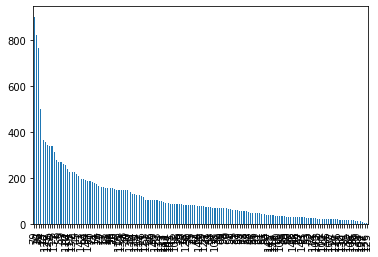

In [79]:
##Exportamos los datos del modelo que nos dio mejores resultados
#Normalización
from sklearn.decomposition import PCA

sumatoria = pesos_usuarios.sum(axis=1)
pesos_norm = pesos_usuarios.div(sumatoria, axis=0).fillna(0)

scaler = MinMaxScaler()
pesos_norm = scaler.fit_transform(pesos_norm.values)

#PCA
# pca = PCA().fit(pesos_norm)

# pca = PCA(n_components=0.95)
# pesos_pca = pca.fit_transform(pesos_norm)

#print("Número de componentes: ",pca.n_components_)
  #Kmeans
k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = num_iter)
k_means.fit_predict(pesos_norm)
centroids = k_means.cluster_centers_
labels = k_means.labels_

  #Desempeño
pres = silhouette_score(pesos_norm, labels)
print("silhouette_score: ", pres)

  #copiamos el dataframe y agregamos los clusters para gráficar la distribución
df2 = pesos_usuarios.copy()
df2["cluster"] = labels
df2.groupby("cluster")["cluster"].count()
display(df2["cluster"].value_counts().plot(kind='bar'))

  #Cálculo de métricas
media = mean_cluster(df2,labels)
desviacion = std_dev_cluster(df2,labels)
data = df2.groupby('cluster')['720'].count()
peque10 = len(data[data<=10])
peque20 = len(data[data<=20])
masGrande = data.max()
#Agregamos los datos a nuestra tabla de resumen para comparar
resumen = resumen.append({'Tecnica':"K-MEANS",
                              'PCA':0.95,
                              'Norm_filas':True,
                              'Norm_col':True,
                              'Precision':pres,
                              'Desviacion_estandar':desviacion,
                              'Media':media,
                              'Coeficiente_variacion':desviacion/media, 
                              'Clusters': num_clusters,
                              "Grupos<20":peque20,
                              "Grupos<10":peque10 , 
                              "Grupo_mas_grande":masGrande}, ignore_index=True)

# Exportación del modelo
Asignaremos nuevamente a todo registro su respectivo id de usuario.
Exportamos a los usuarios con su respectivo cluster en el archivos "grupos.json "

In [80]:
dfp = df2.loc[df2['cluster'] == 12]
dfp.loc[dfp['510'] > 0]

,720,540,510,710,740,810,820,330,860,690,620,150,940,570,840,800,Tesis,300,350,380,130,Mapa,340,980,Revista,Video,700,360,920,750,890,420,650,780,0,910,680,120,370,610,...,830,950,440,20,250,660,760,170,600,230,140,390,180,270,870,430,100,10,160,220,210,Diapositiva,470,400,460,60,200,480,960,310,280,None,Tablet,50,90,Juego,30,Video Juego,Interbibliotecario,cluster


In [81]:
df2

,720,540,510,710,740,810,820,330,860,690,620,150,940,570,840,800,Tesis,300,350,380,130,Mapa,340,980,Revista,Video,700,360,920,750,890,420,650,780,0,910,680,120,370,610,...,830,950,440,20,250,660,760,170,600,230,140,390,180,270,870,430,100,10,160,220,210,Diapositiva,470,400,460,60,200,480,960,310,280,None,Tablet,50,90,Juego,30,Video Juego,Interbibliotecario,cluster
0,2.50,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,29
1,0.50,1.0,1.25,0.0,0.00,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,137
2,0.00,0.0,0.00,3.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,27
3,0.00,0.0,0.00,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,12
4,0.25,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17229,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,73
17230,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,128
17231,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,50
17232,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,7


In [82]:
len(df["ID de usuario ok"].unique())

17234

In [83]:
ids = df["ID de usuario ok"].unique()
df2["ids usuarios"] = ids

In [84]:
len(df2["ids usuarios"].unique())

17234

In [85]:
df2.loc[df2['ids usuarios'] == '11d403e3de4f03317411ba85207601ba616fbd49']

,720,540,510,710,740,810,820,330,860,690,620,150,940,570,840,800,Tesis,300,350,380,130,Mapa,340,980,Revista,Video,700,360,920,750,890,420,650,780,0,910,680,120,370,610,...,950,440,20,250,660,760,170,600,230,140,390,180,270,870,430,100,10,160,220,210,Diapositiva,470,400,460,60,200,480,960,310,280,None,Tablet,50,90,Juego,30,Video Juego,Interbibliotecario,cluster,ids usuarios
328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,9.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,138,11d403e3de4f03317411ba85207601ba616fbd49


In [86]:
#df2
#df2.to_json('/content/drive/MyDrive/UAQUE/Grupos.json')

In [87]:
datasetPrestamos = pd.read_json('/content/drive/MyDrive/UAQUE/Grupos.json')

In [88]:
datasetPrestamos.head()

,720,540,510,710,740,810,820,330,860,690,620,150,940,570,840,800,Tesis,300,350,380,130,Mapa,340,980,Revista,Video,700,360,920,750,890,420,650,780,0,910,680,120,370,610,...,950,440,20,250,660,760,170,600,230,140,390,180,270,870,430,100,10,160,220,210,Diapositiva,470,400,460,60,200,480,960,310,280,None,Tablet,50,90,Juego,30,Video Juego,Interbibliotecario,cluster,ids usuarios
0,2.50,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,15,c361c772cd0220bb16dcfb2ad803e4903334ab94
1,0.50,1.0,1.25,0.0,0.00,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,114,87b0e5a61ed712ddfaf5d478ad68c87c825997e9
2,0.00,0.0,0.00,3.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,61,afe8c17ba351d274fc5671978918f0c93032d88f
3,0.00,0.0,0.00,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,8,6b39c8ff51a36458e3f68233b82c1ce8bd8cc3d3
4,0.25,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,15,a8cd77c9b47b2723fbd8013ce467664f93ad73e6


In [93]:
len(datasetPrestamos.loc[datasetPrestamos['cluster'] == 5])

336

#Centroides por cluster

In [90]:
centroids = k_means.cluster_centers_
print('Num clusters:', len(centroids))
print('Num Deweys', len(centroids[5]))
display(centroids[5])

# De centroides negativos a 0
for i in range(len(centroids)):
  for j in range(len(centroids[0])-1):
    if centroids[i][j] < 0:
      centroids[i][j] = 0

df_centroids = pd.DataFrame(centroids, columns = df2.columns[:len(df2.columns)-2])
df_centroids["Sum"] = df_centroids.sum(axis = 1)
display(df_centroids)

temp_matrix = df_centroids.to_numpy()

for i in range(len(temp_matrix)):
  for j in range(len(temp_matrix[0]) - 1):
    if temp_matrix[i][len(temp_matrix[0]) - 1] > 0:
      temp_matrix[i][j] = temp_matrix[i][j] * 100
df_centroids_porcentaje = pd.DataFrame(temp_matrix, columns=df_centroids.columns)
display(df_centroids_porcentaje)


Num clusters: 150
Num Deweys 108


array([ 3.70872256e-03,  5.20417043e-18,  4.20132089e-03, -6.93889390e-18,
        3.96436498e-03,  9.06514366e-03,  4.79135432e-03,  1.06784490e-02,
        3.05760206e-02, -5.20417043e-18,  2.00481155e-04,  1.01220176e-02,
        5.64788250e-03,  6.41679380e-03,  2.24240355e-03,  5.64294848e-03,
        8.67361738e-18,  4.26045908e-02,  1.95185426e-03, -1.51788304e-18,
        7.06043630e-03,  2.71050543e-19,  4.14198263e-02,  4.89338248e-03,
        4.19507206e-03,  1.64911717e-03,  6.97732219e-03,  3.44827586e-03,
        1.45107718e-02,  1.60035367e-03,  1.08865424e-02,  7.09756868e-03,
        3.27077460e-03,  2.91442520e-03,  1.68253045e-03,  5.86441473e-05,
        3.44827586e-03,  9.16803503e-03,  1.55487699e-02,  2.12128649e-02,
       -3.25260652e-19,  7.27512343e-03,  2.34576589e-04,  1.30104261e-18,
        5.20417043e-18, -6.50521303e-19,  5.83501792e-04,  3.74812594e-05,
        6.50618087e-04,  5.74712644e-03,  6.91981944e-03,  3.64259900e-03,
        4.27630580e-02,  

,720,540,510,710,740,810,820,330,860,690,620,150,940,570,840,800,Tesis,300,350,380,130,Mapa,340,980,Revista,Video,700,360,920,750,890,420,650,780,0,910,680,120,370,610,...,830,950,440,20,250,660,760,170,600,230,140,390,180,270,870,430,100,10,160,220,210,Diapositiva,470,400,460,60,200,480,960,310,280,None,Tablet,50,90,Juego,30,Video Juego,Interbibliotecario,Sum
0,0.000099,5.204170e-18,0.009275,0.000000e+00,0.009615,0.000198,7.070707e-03,2.006249e-02,0.004377,0.000000e+00,0.000000,3.473622e-03,4.329004e-03,1.416029e-04,0.002218,0.003030,1.387779e-17,9.566216e-03,0.000198,1.010101e-03,0.005169,3.523657e-19,0.000396,1.010101e-03,0.002694,0.003367,0.000292,9.902951e-04,0.000198,5.204170e-18,0.007492,1.980590e-04,1.313131e-02,4.720098e-05,0.000198,0.000000,0.000000,0.000679,0.003026,0.009296,...,6.357279e-04,0.000000e+00,0.000000,4.238186e-04,3.252607e-19,0.000000,0.000000e+00,3.304069e-04,3.252607e-19,4.248088e-04,1.734723e-18,0.000000e+00,8.075260e-01,0.000000e+00,7.788162e-04,0.000000,0.005051,5.050505e-03,2.164502e-03,0.006183,2.832059e-04,8.417508e-04,2.832059e-04,8.673617e-19,6.938894e-18,2.710505e-19,0.000000,0.000000e+00,0.000000e+00,8.131516e-20,0.000000e+00,0.0,1.490778e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.776264e-20,-2.168404e-19,1.000260
1,0.010211,1.084755e-02,0.018817,4.858644e-03,0.035868,0.014056,1.070493e-02,3.902540e-02,0.029701,2.821022e-03,0.021068,1.568416e-02,7.259355e-03,3.216329e-02,0.008302,0.009654,6.374597e-03,4.075713e-02,0.004507,4.421451e-04,0.017854,5.421011e-19,0.037405,1.000376e-02,0.003143,0.003696,0.008254,1.540852e-02,0.008108,5.638840e-03,0.008729,9.179906e-03,2.699282e-02,1.315480e-02,0.015237,0.001607,0.000570,0.008565,0.014581,0.273341,...,6.018570e-03,1.540927e-03,0.001829,5.194098e-03,4.622781e-04,0.002129,2.276825e-18,5.047107e-03,2.444589e-04,2.871637e-03,1.021377e-03,3.903128e-18,8.710146e-03,8.898261e-04,1.897773e-04,0.000000,0.000300,0.000000e+00,2.838140e-03,0.001854,1.923077e-04,1.375057e-03,0.000000e+00,4.449023e-03,5.129256e-03,0.000000e+00,0.000466,4.065758e-20,4.807692e-04,9.615385e-04,2.696322e-04,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.602564e-03,7.396450e-04,1.000156
2,0.007209,1.391374e-02,0.260402,1.734723e-18,0.003788,0.015802,7.294947e-03,1.723555e-02,0.032261,4.336809e-19,0.012211,2.525253e-03,9.018759e-03,2.880691e-01,0.005682,0.005051,1.515152e-02,8.726506e-03,0.000716,6.505213e-19,0.014464,0.000000e+00,0.017424,1.177187e-02,0.019284,0.005682,0.001021,3.952569e-03,0.005852,1.021450e-03,0.031205,3.546703e-03,1.101204e-02,2.525253e-03,0.008384,0.000000,0.018939,0.006494,0.016143,0.018987,...,2.525253e-03,0.000000e+00,0.000000,7.158196e-04,0.000000e+00,0.005566,0.000000e+00,4.501537e-03,2.168404e-19,7.158196e-04,7.158196e-04,8.673617e-19,2.020202e-03,6.505213e-19,0.000000e+00,0.000000,0.000000,0.000000e+00,2.525253e-03,0.000000,3.252607e-19,0.000000e+00,5.421011e-20,8.673617e-19,7.724719e-03,5.421011e-20,0.000716,0.000000e+00,5.421011e-20,2.710505e-20,0.000000e+00,0.0,0.000000e+00,1.355253e-20,1.355253e-20,2.710505e-20,2.710505e-20,0.000000e+00,1.626303e-19,1.000000
3,0.004331,1.909629e-03,0.005820,1.267945e-03,0.004327,0.008093,2.678618e-03,2.836486e-02,0.012836,0.000000e+00,0.009387,3.261758e-03,2.717929e-03,4.719176e-03,0.001019,0.002553,4.560200e-03,1.892903e-02,0.008126,7.396450e-04,0.003309,4.878910e-19,0.658369,8.949942e-03,0.006872,0.005822,0.003806,1.267711e-02,0.007496,2.689023e-03,0.004389,1.373879e-03,1.998666e-02,5.858886e-03,0.004869,0.001121,0.000214,0.003597,0.004390,0.015831,...,2.343099e-03,1.040507e-03,0.000158,2.077487e-04,2.311391e-04,0.000474,1.314924e-04,1.887619e-03,1.479290e-03,5.908393e-03,1.740341e-04,0.000000e+00,3.438529e-03,4.430801e-03,2.625958e-05,0.001938,0.000411,0.000000e+00,8.105307e-04,0.000078,9.392317e-05,3.470534e-03,0.000000e+00,1.551152e-03,3.848701e-03,0.000000e+00,0.000000,0.000000e+00,9.543806e-05,2.168404e-19,5.421011e-20,0.0,0.000000e+00,0.000000e+00,1.084202e-19,2.032879e-20,

,720,540,510,710,740,810,820,330,860,690,620,150,940,570,840,800,Tesis,300,350,380,130,Mapa,340,980,Revista,Video,700,360,920,750,890,420,650,780,0,910,680,120,370,610,...,830,950,440,20,250,660,760,170,600,230,140,390,180,270,870,430,100,10,160,220,210,Diapositiva,470,400,460,60,200,480,960,310,280,None,Tablet,50,90,Juego,30,Video Juego,Interbibliotecario,Sum
0,0.009903,5.204170e-16,0.927499,0.000000e+00,0.961474,0.019806,7.070707e-01,2.006249e+00,0.437710,0.000000e+00,0.000000,3.473622e-01,4.329004e-01,1.416029e-02,0.221826,0.303030,1.387779e-15,9.566216e-01,0.019806,1.010101e-01,0.516851,3.523657e-17,0.039612,1.010101e-01,0.269360,0.336700,0.029246,9.902951e-02,0.019806,5.204170e-16,0.749158,1.980590e-02,1.313131e+00,4.720098e-03,0.019806,0.000000,0.000000,0.067932,0.302647,0.929555,...,6.357279e-02,0.000000e+00,0.000000,4.238186e-02,3.252607e-17,0.000000,0.000000e+00,3.304069e-02,3.252607e-17,4.248088e-02,1.734723e-16,0.000000e+00,8.075260e+01,0.000000e+00,7.788162e-02,0.000000,0.505051,5.050505e-01,2.164502e-01,0.618333,2.832059e-02,8.417508e-02,2.832059e-02,8.673617e-17,6.938894e-16,2.710505e-17,0.000000,0.000000e+00,0.000000e+00,8.131516e-18,0.000000e+00,0.0,1.490778e-17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.776264e-18,-2.168404e-17,1.000260
1,1.021057,1.084755e+00,1.881667,4.858644e-01,3.586831,1.405626,1.070493e+00,3.902540e+00,2.970114,2.821022e-01,2.106774,1.568416e+00,7.259355e-01,3.216329e+00,0.830160,0.965367,6.374597e-01,4.075713e+00,0.450690,4.421451e-02,1.785392,5.421011e-17,3.740528,1.000376e+00,0.314349,0.369559,0.825430,1.540852e+00,0.810815,5.638840e-01,0.872887,9.179906e-01,2.699282e+00,1.315480e+00,1.523697,0.160692,0.056953,0.856534,1.458147,27.334128,...,6.018570e-01,1.540927e-01,0.182944,5.194098e-01,4.622781e-02,0.212881,2.276825e-16,5.047107e-01,2.444589e-02,2.871637e-01,1.021377e-01,3.903128e-16,8.710146e-01,8.898261e-02,1.897773e-02,0.000000,0.030048,0.000000e+00,2.838140e-01,0.185427,1.923077e-02,1.375057e-01,0.000000e+00,4.449023e-01,5.129256e-01,0.000000e+00,0.046626,4.065758e-18,4.807692e-02,9.615385e-02,2.696322e-02,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.602564e-01,7.396450e-02,1.000156
2,0.720933,1.391374e+00,26.040194,1.734723e-16,0.378788,1.580157,7.294947e-01,1.723555e+00,3.226108,4.336809e-17,1.221109,2.525253e-01,9.018759e-01,2.880691e+01,0.568182,0.505051,1.515152e+00,8.726506e-01,0.071582,6.505213e-17,1.446426,0.000000e+00,1.742439,1.177187e+00,1.928375,0.568182,0.102145,3.952569e-01,0.585177,1.021450e-01,3.120491,3.546703e-01,1.101204e+00,2.525253e-01,0.838388,0.000000,1.893939,0.649351,1.614336,1.898694,...,2.525253e-01,0.000000e+00,0.000000,7.158196e-02,0.000000e+00,0.556586,0.000000e+00,4.501537e-01,2.168404e-17,7.158196e-02,7.158196e-02,8.673617e-17,2.020202e-01,6.505213e-17,0.000000e+00,0.000000,0.000000,0.000000e+00,2.525253e-01,0.000000,3.252607e-17,0.000000e+00,5.421011e-18,8.673617e-17,7.724719e-01,5.421011e-18,0.071582,0.000000e+00,5.421011e-18,2.710505e-18,0.000000e+00,0.0,0.000000e+00,1.355253e-18,1.355253e-18,2.710505e-18,2.710505e-18,0.000000e+00,1.626303e-17,1.000000
3,0.433083,1.909629e-01,0.582036,1.267945e-01,0.432693,0.809285,2.678618e-01,2.836486e+00,1.283624,0.000000e+00,0.938702,3.261758e-01,2.717929e-01,4.719176e-01,0.101938,0.255308,4.560200e-01,1.892903e+00,0.812639,7.396450e-02,0.330891,4.878910e-17,65.836869,8.949942e-01,0.687246,0.582159,0.380575,1.267711e+00,0.749566,2.689023e-01,0.438940,1.373879e-01,1.998666e+00,5.858886e-01,0.486917,0.112051,0.021368,0.359665,0.439008,1.583085,...,2.343099e-01,1.040507e-01,0.015790,2.077487e-02,2.311391e-02,0.047354,1.314924e-02,1.887619e-01,1.479290e-01,5.908393e-01,1.740341e-02,0.000000e+00,3.438529e-01,4.430801e-01,2.625958e-03,0.193758,0.041101,0.000000e+00,8.105307e-02,0.007786,9.392317e-03,3.470534e-01,0.000000e+00,1.551152e-01,3.848701e-01,0.000000e+00,0.000000,0.000000e+00,9.543806e-03,2.168404e-17,5.421011e-18,0.0,0.000000e+00,0.000000e+00,1.084202e-17,2.032879e-

In [91]:
dfp = df2.loc[df2['cluster'] == 5]
#print(len(dfp))
#display(dfp)
dfp.loc[dfp['350'] > 0]

df2_copy = df2.iloc[: , : -3]
df2_copy["Sum"] = df2_copy.sum(axis = 1)

df2_total = df2
df2_total['Total'] = df2_copy["Sum"]

df2_porcentaje = df2_total
num_columns = len(df2_porcentaje.columns) - 3
#print(df2_porcentaje.iloc[0]["Total"])

temp_matrix = df2_porcentaje.to_numpy()

for i in range(len(df2_porcentaje)):
  for j in range(num_columns):
    if temp_matrix[i][len(temp_matrix[0]) - 1] > 0:
      temp_matrix[i][j] = (temp_matrix[i][j]*100) / temp_matrix[i][len(temp_matrix[0]) - 1]

df2_porcentaje = pd.DataFrame(temp_matrix, columns=df2_porcentaje.columns)
display(df2_porcentaje)



,720,540,510,710,740,810,820,330,860,690,620,150,940,570,840,800,Tesis,300,350,380,130,Mapa,340,980,Revista,Video,700,360,920,750,890,420,650,780,0,910,680,120,370,610,...,440,20,250,660,760,170,600,230,140,390,180,270,870,430,100,10,160,220,210,Diapositiva,470,400,460,60,200,480,960,310,280,None,Tablet,50,90,Juego,30,Video Juego,Interbibliotecario,cluster,ids usuarios,Total
0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,c361c772cd0220bb16dcfb2ad803e4903334ab94,2.5
1,9.09091,18.1818,22.7273,0,0,9.09091,0,0,0,0,0,0,0,0,0,0,0,4.54545,0,0,0,0,18.1818,0,0,0,0,13.6364,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,137,87b0e5a61ed712ddfaf5d478ad68c87c825997e9,5.5
2,0,0,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,afe8c17ba351d274fc5671978918f0c93032d88f,3
3,0,0,0,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,6b39c8ff51a36458e3f68233b82c1ce8bd8cc3d3,0.25
4,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,a8cd77c9b47b2723fbd8013ce467664f93ad73e6,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17229,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,20,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,73,da2055e503d6e3c162ed8708b15235807abd9547,15
17230,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33.3333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,33.3333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,0506de90d38f6562213fb9239dd2e0c32ced2869,6
17231,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,18049306edc70474f62da968b2bb8e8fe496a2ca,1
17232,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18.1818,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18.1818,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,23fa3196e4b1917467e020242458e497be14ae20,11


107
107
720            3.708723e-01
540            5.204170e-16
510            4.201321e-01
710            0.000000e+00
740            3.964365e-01
                   ...     
50             0.000000e+00
90             1.355253e-18
Juego          0.000000e+00
30             0.000000e+00
Video Juego    6.776264e-18
Name: 5, Length: 107, dtype: float64


Text(0.5, 0, 'Dewey')

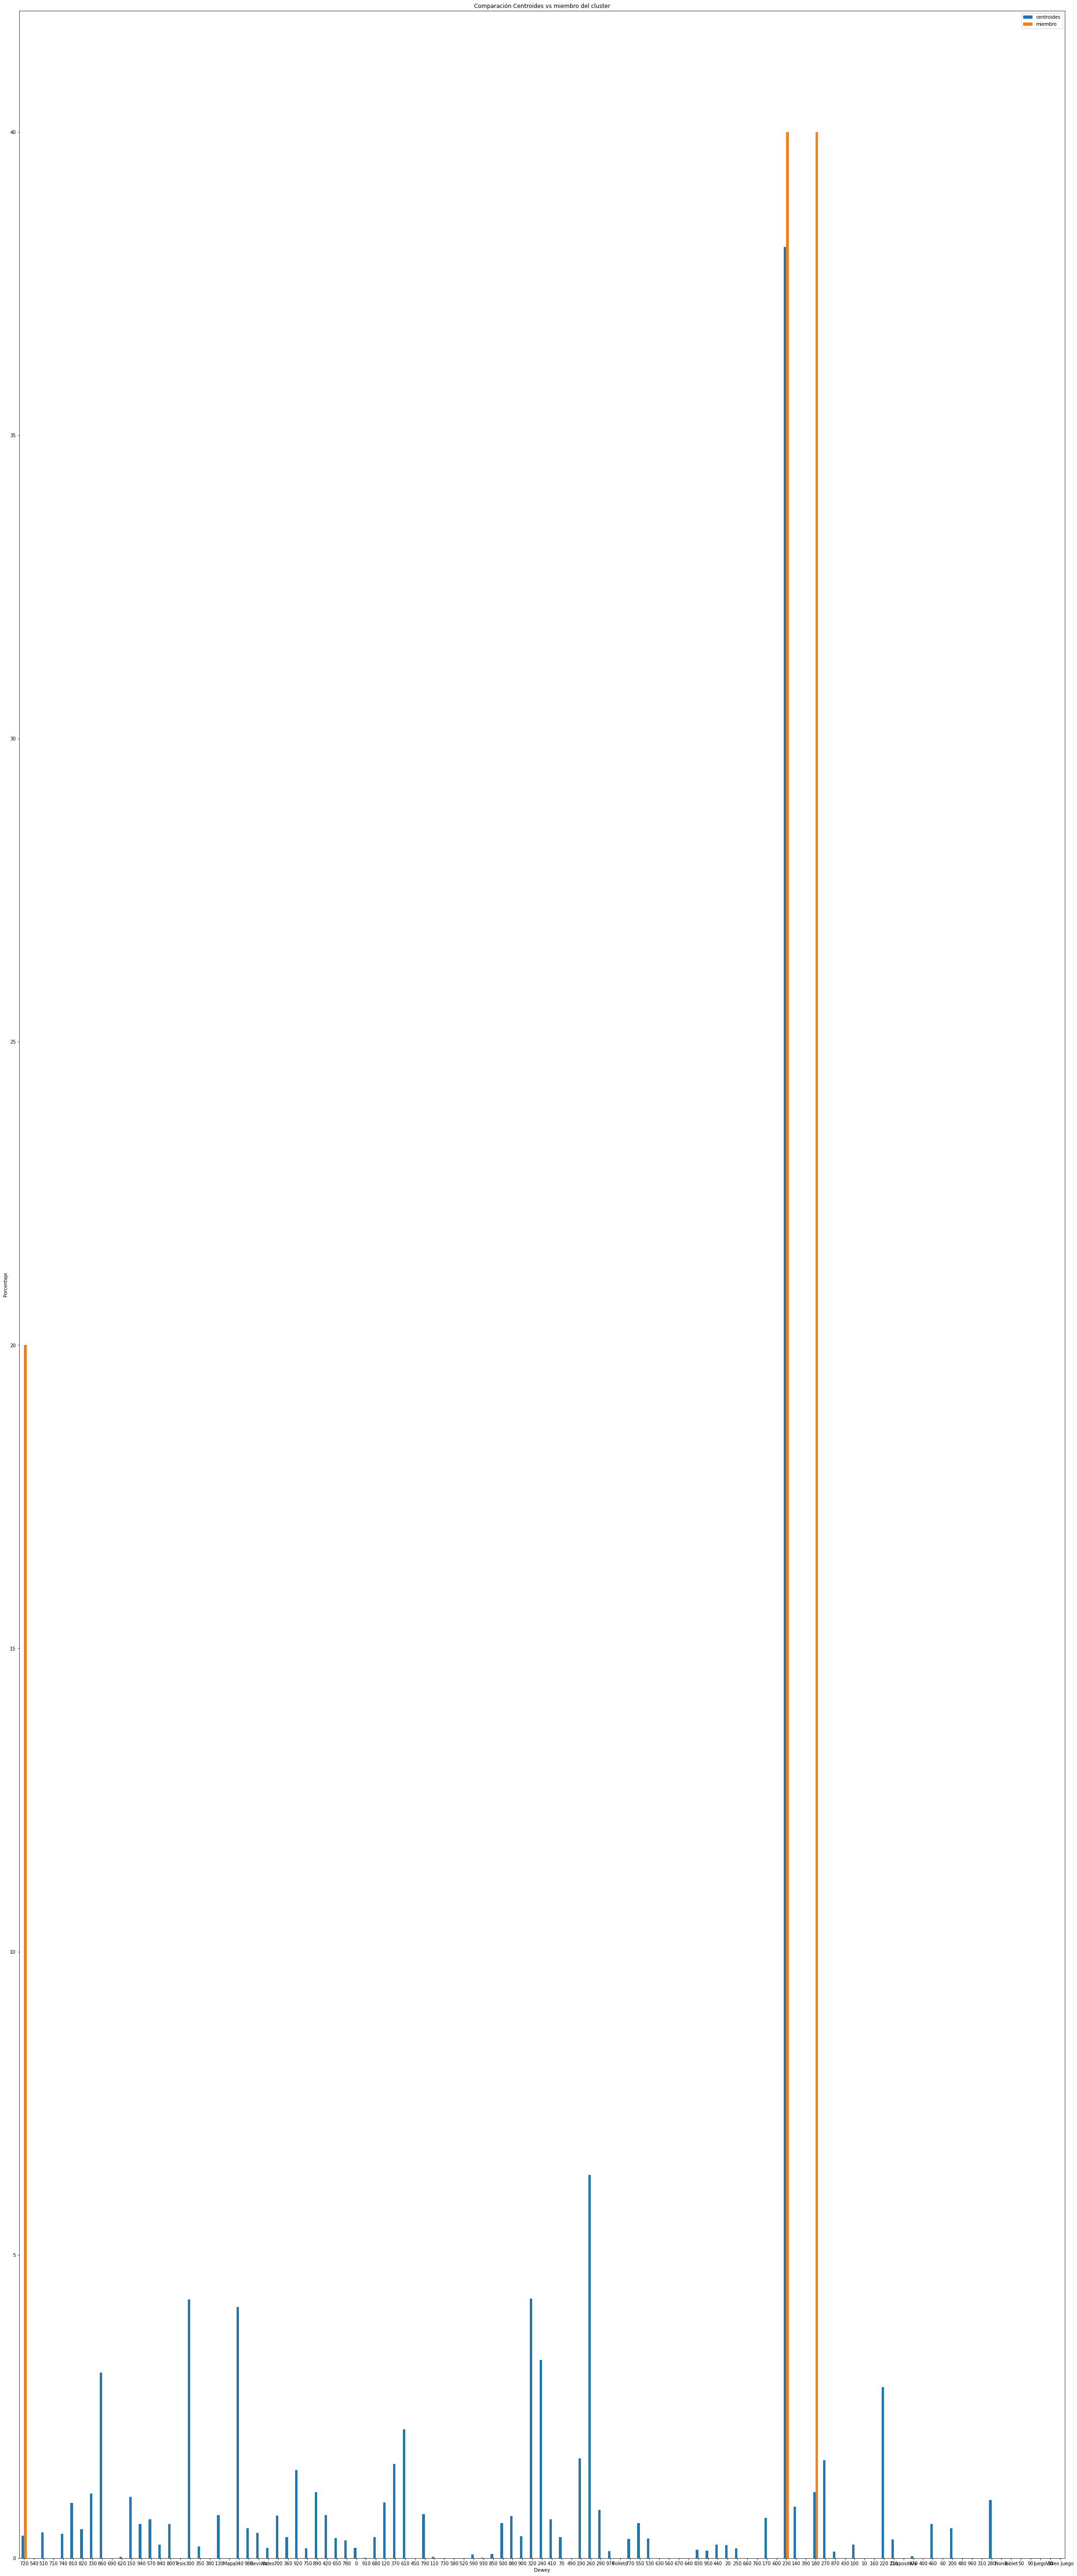

In [92]:
import matplotlib.pyplot as plt
labels = df_centroids.columns[:len(df_centroids.columns)-2]

print(len(df_centroids_porcentaje.columns)-2)
print(len(df2_porcentaje.columns)-4)

#Datos de los centroides de un cluster (%)
temp_centroids = df_centroids_porcentaje.iloc[5][:len(df_centroids_porcentaje.columns) - 2]
print(temp_centroids)

#Datos del primer miembro del cluster anterior (%)
temp_miembro = df2_porcentaje.loc[df2_porcentaje['cluster'] == 5].iloc[0][:len(df2_porcentaje.columns) - 4]

index = df_centroids_porcentaje.columns[:len(df_centroids_porcentaje.columns) - 2]

df_plot = pd.DataFrame({'centroides':temp_centroids, 'miembro':temp_miembro}, index=index)

ax = df_plot.plot.bar(rot=0, figsize=(40, 100), title="Comparación Centroides vs miembro del cluster")
ax.set_ylabel('Porcentaje')
ax.set_xlabel("Dewey")